## Import dependencies

In [28]:
import os
from pathlib import Path
from timeit import default_timer as timer
from typing import List
import xml.etree.ElementTree as ET
import zipfile


from bs4 import BeautifulSoup
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as FT
import torchinfo
import torchmetrics

from tqdm.auto import tqdm

from utils import (
    convert_annotations_to_yolo,
    intersection_over_union,
    non_max_suppression,
    mean_average_precision,
    cellboxes_to_boxes,
    get_bboxes)

from loss import YoloLoss

## Download and format data

In [29]:
if Path('data/face-mask-detection.zip').exists():
    print('Data is already downloaded')
else:
    os.makedirs("data", exist_ok=True)
    !kaggle datasets download -d andrewmvd/face-mask-detection -p data

Data is already downloaded


In [30]:
data_path = Path('data/')
mask_path = data_path / 'face-mask-detection'

if mask_path.is_dir():
  print(f'Folder {mask_path} already exists')
else:
  print(f'Creating {mask_path}')
  mask_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(data_path / 'face-mask-detection.zip', 'r') as zip_ref:
    zip_ref.extractall(mask_path)

Folder data/face-mask-detection already exists


In [31]:
classes = ["with_mask", "mask_weared_incorrect", "without_mask"]
input_dir = mask_path / "annotations/"
output_dir = mask_path / "labels/"
image_dir = mask_path / "images/"

if len(list(output_dir.glob('*'))) == len(list(input_dir.glob('*'))):
    print(f'Labels already exist in target dir')
else:
    convert_annotations_to_yolo(classes=classes, input_dir=input_dir, output_dir=output_dir, image_dir=image_dir)


Labels already exist in target dir


## Create torch dataset

In [32]:
class YoloDataset(Dataset):
    def __init__(self, data_dir, transform=None, S=7, C=3, B=2):
        self.data_dir = data_dir
        self.transform = transform
        self.images = sorted(data_dir.glob('*/*.png'))
        self.labels = sorted(data_dir.glob('*/*.txt'))
        self.S = S
        self.C = C
        self.B = B
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_file = self.images[index]
        img = Image.open(image_file).convert('RGB')
        label_file = self.labels[index]
        with open(label_file, 'r') as f:
            boxes = []
            for line in f:
                label = line.strip().split(' ')
                boxes.append([int(label[0]), float(label[1]), float(label[2]), float(label[3]), float(label[4])])
        
        
        if self.transform:
            img = self.transform(img)

        label_matrix = torch.zeros(self.S, self.S, self.C + 5 * 2)

        for box in boxes:
            class_label, x, y, width, height = box
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i
            width_cell, height_cell = (
                width * self.S,
                height * self.S
            )

        if label_matrix[i, j, 3] == 0:
            label_matrix[i, j, 3] = 1
            box_coordinates = torch.tensor(
                [x_cell, y_cell, width_cell, height_cell]
            )
            label_matrix[i, j, 4:8] = box_coordinates
            label_matrix[i, j, class_label] = 1

        return img, label_matrix

## Create model

In [33]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [113]:
class TinyYoloV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack_1 = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=16),
            nn.MaxPool2d(2),
            ConvBlock(in_channels=16, out_channels=32),
            nn.MaxPool2d(2),
            ConvBlock(in_channels=32, out_channels=64),
            nn.MaxPool2d(2),
            ConvBlock(in_channels=64, out_channels=128),
            nn.MaxPool2d(2),
            ConvBlock(in_channels=128, out_channels=256),
            nn.MaxPool2d(2),
            ConvBlock(in_channels=256, out_channels=512),
            nn.MaxPool2d(2)
        )

        self.conv_stack_2 = nn.Sequential(
            ConvBlock(in_channels=512, out_channels=1024),
            ConvBlock(in_channels=1024, out_channels=1024),
            ConvBlock(in_channels=1024, out_channels=1024)
        )

        self.fcs = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1024*7*7, out_features= 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, 7*7*(3+5*2))
        )

    def forward(self, x):
        return self.fcs(self.conv_stack_2(self.conv_stack_1(x)))

## Sanity check - overfit on single batch

In [114]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [115]:
transform = transforms.Compose(
    [transforms.Resize(size=(448, 448)),
    transforms.ToTensor()]
)

tiny = TinyYoloV1().to(device)
data = YoloDataset(mask_path, transform)
data_loader = DataLoader(data, batch_size=2, shuffle=True)

loss_fn = YoloLoss().to(device)
optimizer = torch.optim.Adam(params=tiny.parameters(), lr=2e-5)

In [116]:
epochs = 250
X, y = next(iter(data_loader))
X, y = X.to(device), y.to(device)
tiny.to(device)

start = timer()
for epoch in range(epochs):
    train_loss = 0
    tiny.train()
    y_logits = tiny(X)
    loss = loss_fn(y_logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0: print(f'Loss: {loss.item()}')

end = timer()
print(f'\n--------\n{start-end:.3f} seconds')

Loss: 36.03814697265625
Loss: 5.635375499725342
Loss: 1.07777738571167
Loss: 0.19026227295398712
Loss: 0.0142054483294487
Loss: 0.0007699529523961246
Loss: 7.327221828745678e-05
Loss: 5.155080089025432e-06
Loss: 3.45191523365429e-07
Loss: 2.771418117220037e-08

--------
-31.576 seconds


## Run the experiment

In [117]:
LEARNING_RATE = 2e-5
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
BATCH_SIZE = 16
WEIGHT_DECAY = 0.0
EPOCHS = 150

In [118]:
def train_step(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device = DEVICE        
):
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)

    print(f'Train Loss: {train_loss}')

In [119]:
model = TinyYoloV1().to(DEVICE)
optimizer = optim.Adam(params=model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss(S=7, B=2, C=3).to(device)

In [120]:
transform = transforms.Compose([
    transforms.Resize(size=(448, 448)),
    transforms.ToTensor()
])

In [121]:
data = YoloDataset(mask_path, transform)
data_laoder = DataLoader(data,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         drop_last=True)

In [122]:
for epoch in tqdm(range(EPOCHS)):
  pred_boxes, target_boxes = get_bboxes(data_loader, model, iou_threshold=0.5, threshold=0.4, device=DEVICE)
  mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, n_classes=3, box_format='midpoint')
  if mean_avg_prec > 0.8:
    print(f'\n--------\nFinal mAP: {mean_avg_prec:.3f}\n--------')
    break
  print(f'mAP: {mean_avg_prec:.4f}')
  train_step(model=model, data_loader=data_loader, loss_fn=loss_fn, optimizer=optimizer)

  0%|          | 0/150 [00:00<?, ?it/s]

mAP: 0.0000
Train Loss: 19.75170470065758
mAP: 0.0826
Train Loss: 9.274214376052035
mAP: 0.1418
Train Loss: 6.2893395730985695
mAP: 0.1027
Train Loss: 5.516878210688643
mAP: 0.1250
Train Loss: 4.781669015906734
mAP: 0.1105
Train Loss: 4.221866573047861
mAP: 0.1055
Train Loss: 4.318381522801777
mAP: 0.1116
Train Loss: 4.266027427668873
mAP: 0.0898
Train Loss: 4.258696381883822
mAP: 0.1174
Train Loss: 5.932442275645862
mAP: 0.1279
Train Loss: 4.345104875553408
mAP: 0.1291
Train Loss: 3.8600123361346315
mAP: 0.1310
Train Loss: 3.4911108871254486
mAP: 0.1224
Train Loss: 3.185919483316587
mAP: 0.1854
Train Loss: 3.163512015789398
mAP: 0.1771
Train Loss: 3.581830747791978
mAP: 0.1586
Train Loss: 3.8936993810555416
mAP: 0.1779
Train Loss: 3.210033095971762
mAP: 0.1811
Train Loss: 2.9799256076299057
mAP: 0.1767
Train Loss: 2.8465914200005544
mAP: 0.2354
Train Loss: 2.9126430546092763
mAP: 0.2582
Train Loss: 2.7070365352708787
mAP: 0.2111
Train Loss: 2.843178021963642
mAP: 0.3319
Train Loss: 2.

## Visually examine (disapointing) results

In [123]:
class_to_idx = {float(i): c for i, c in enumerate(classes)}

In [146]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        label = box[0]
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )

        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/8.0
        l = ax.annotate(
            class_to_idx[label],
            (cx, cy),
            fontsize=8,
            fontweight="bold",
            color="white",
            ha='center',
            va='center'
        )
        l.set_bbox(
        dict(facecolor='red', alpha=0.5, edgecolor='red')
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


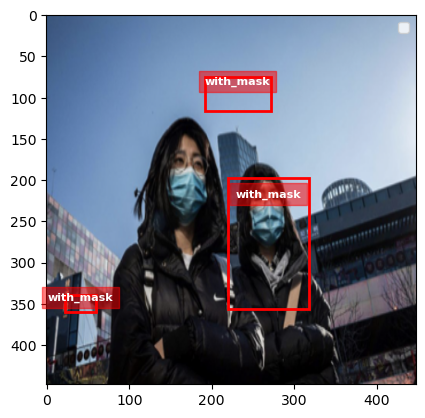

In [145]:
image_loader = DataLoader(data, batch_size=1, shuffle=True)
x, y = next(iter(image_loader))

model.eval()
with torch.inference_mode():
  bboxes = cellboxes_to_boxes(model(x.to(DEVICE)))
  non_max_sup = non_max_suppression(bboxes[0], iou_threshold=0.4, prob_threshold=0.7)
  plot_image(x.squeeze(0).permute(1, 2, 0).to('cpu'), non_max_sup)

In [148]:
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True 
)

MODEL_NAME = 'TinyYoloV1.pt'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models/TinyYoloV1.pt
